In [10]:
%matplotlib inline

Import Lib dan Module

In [11]:
import os
import tensorflow as tf
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

Pre-Processing

In [12]:
def load_and_preprocess_data(directory, img_size=(224, 224)):
    images = []
    labels = []
    
    # Load Clean 
    clean_path = os.path.join(directory, 'Clean-samples')
    for img_name in os.listdir(clean_path):
        img_path = os.path.join(clean_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = cv2.GaussianBlur(img, (3,3), 0)     # PreProc Gambar
            
            # Clahe
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            l = clahe.apply(l)
            img = cv2.merge((l,a,b))
            img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
            
            images.append(img)
            labels.append(0)

     # Load Dirty
    dirty_path = os.path.join(directory, 'Dirty-samples')
    for img_name in os.listdir(dirty_path):
        img_path = os.path.join(dirty_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = cv2.GaussianBlur(img, (3,3), 0)
            
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            l = clahe.apply(l)
            img = cv2.merge((l,a,b))
            img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)
            
            images.append(img)
            labels.append(1)
    
    return np.array(images), np.array(labels)


Base Model (Pre Trained)

In [13]:
def create_transfer_model(input_shape):
    # MobileNetV2
    base_model = tf.keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    
    return model

Model CNN

In [14]:
def main():
    # Param
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 4
    EPOCHS = 30
    LEARNING_RATE = 0.0005
    
    # Metric Track
    fold_scores = []
    fold_f1_scores = []
    
    # Load & preprocess data
    X, y = load_and_preprocess_data('Dataset/train', IMG_SIZE)
    
    # Normalisasi
    X = X.astype('float32') / 255.0
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.8,1.2],
        validation_split=0.2
    )
    
    # 3-fold k-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f'Training fold {fold + 1}/3')
        
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Convert ke tf dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
        train_dataset = train_dataset.shuffle(buffer_size=len(X_train_fold))
        train_dataset = train_dataset.batch(BATCH_SIZE)
        
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
        val_dataset = val_dataset.batch(BATCH_SIZE)
        
        # Model
        model = create_transfer_model((IMG_SIZE[0], IMG_SIZE[1], 3))
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC', Precision(), Recall()]
        )
        
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=7,
                restore_best_weights=True,
                min_delta=0.01
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=0.00001
            )
        ]
        
        class_weights = {
            0: len(y_train_fold[y_train_fold==1]) / len(y_train_fold),
            1: len(y_train_fold[y_train_fold==0]) / len(y_train_fold)
        }
        
        # Train
        history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=val_dataset,
            callbacks=callbacks,
            class_weight=class_weights
        )
        
        # Evaluasi
        scores = model.evaluate(X_val_fold, y_val_fold)
        fold_scores.append(scores[1])
        
        # Get Pred
        y_pred = model.predict(X_val_fold)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # F1 score
        f1 = f1_score(y_val_fold, y_pred_classes)
        fold_f1_scores.append(f1)
        
        print(f'\nFold {fold + 1} Metrics:')
        print(f'Accuracy: {scores[1]:.4f}')
        print(f'AUC: {scores[2]:.4f}')
        print(f'Precision: {scores[3]:.4f}')
        print(f'Recall: {scores[4]:.4f}')
        print(f'F1-Score: {f1:.4f}')
        
        print(f'\nClassification Report:')
        print(classification_report(y_val_fold, y_pred_classes))

        plt.figure(figsize=(8, 6))
        conf_matrix = confusion_matrix(y_val_fold, y_pred_classes)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f'confusion_matrix_fold{fold+1}.png')
        plt.close()
        
        # Best Model
        if fold == np.argmax(fold_f1_scores):
            try:
                save_path = f'best_water_quality_model_fold{fold+1}.h5'  # Changed to .h5
                model.save(save_path, save_format='h5')  # Explicitly specify format
                print(f"Successfully saved model for fold {fold+1}")
                
                # Verify the saved model
                try:
                    test_load = tf.keras.models.load_model(save_path, compile=False)
                    print(f"Successfully verified model loading for fold {fold+1}")
                except Exception as e:
                    print(f"Error verifying model for fold {fold+1}: {e}")
                    
            except Exception as e:
                print(f"Error saving model for fold {fold+1}: {e}")
    
    # Overall
    print('\nOverall Performance:')
    print(f'Average accuracy across folds: {np.mean(fold_scores):.4f}')
    print(f'Best fold accuracy: {np.max(fold_scores):.4f}')
    print(f'Average F1 score across folds: {np.mean(fold_f1_scores):.4f}')
    print(f'Best fold F1 score: {np.max(fold_f1_scores):.4f}')
    
       # Plot training history for best fold
    best_fold = np.argmax(fold_f1_scores)
    with open(f'training_history_fold{best_fold+1}.json', 'r') as f:
        best_history = json.load(f)

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(best_history['accuracy'], label='Training Accuracy')
    plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(best_history['loss'], label='Training Loss')
    plt.plot(best_history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precision-Recall plot
    plt.subplot(1, 3, 3)
    # First find which precision/recall keys are available
    precision_key = None
    recall_key = None
    
    for key in best_history.keys():
        if key.startswith('precision_'):
            precision_key = key
        if key.startswith('recall_'):
            recall_key = key
            
    if precision_key and recall_key:
        plt.plot(best_history[precision_key], label='Precision')
        plt.plot(best_history[recall_key], label='Recall')
        plt.title('Precision and Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

Run

In [15]:
if __name__ == "__main__":
    main()

Training fold 1/3
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - AUC: 0.5499 - accuracy: 0.5425 - loss: 0.3970 - precision_1: 0.5496 - recall_1: 0.5918 - val_AUC: 0.6077 - val_accuracy: 0.5714 - val_loss: 0.7680 - val_precision_1: 0.8000 - val_recall_1: 0.2667 - learning_rate: 5.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - AUC: 0.8728 - accuracy: 0.7510 - loss: 0.2313 - precision_1: 0.8491 - recall_1: 0.6628 - val_AUC: 0.7051 - val_accuracy: 0.6071 - val_loss: 0.6975 - val_precision_1: 0.8333 - val_recall_1: 0.3333 - learning_rate: 5.0000e-04
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - AUC: 0.9320 - accuracy: 0.8122 - loss: 0.1738 - precision_1: 0.8762 - recall_1: 0.7625 - val_AUC: 0.7487 - val_accuracy: 0.6071 - val_loss: 0.6709 - val_precision_1: 0.7500 - val_recall_1: 0.4000 - learning_rate: 5.0000e-04
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - AUC: 0.8394 - accuracy: 0.6918 - loss: 0.2611 - precision_1: 0.7880 - recall_1: 0.5956 - val_AUC:


Fold 1 Metrics:
Accuracy: 0.7500
AUC: 0.8128
Precision: 0.9000
Recall: 0.6000
F1-Score: 0.7200

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.92      0.77        13
           1       0.90      0.60      0.72        15

    accuracy                           0.75        28
   macro avg       0.78      0.76      0.75        28
weighted avg       0.79      0.75      0.75        28

Successfully saved model for fold 1
Successfully verified model loading for fold 1
Training fold 2/3
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - AUC: 0.6517 - accuracy: 0.6085 - loss: 0.3610 - precision_2: 0.7466 - recall_2: 0.5803 - val_AUC: 0.7308 - val_accuracy: 0.5714 - val_loss: 0.6318 - val_precision_2: 0.7143 - val_recall_2: 0.3333 - learning_rate: 5.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - AUC: 0.6792 - accuracy: 0.6795 - loss: 0.3344 - precision_2: 0.6279 - recall_2: 0.6961 - val_AUC: 0.7744 - val_accuracy: 


Fold 2 Metrics:
Accuracy: 0.8929
AUC: 0.9487
Precision: 0.9286
Recall: 0.8667
F1-Score: 0.8966

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.93      0.87      0.90        15

    accuracy                           0.89        28
   macro avg       0.89      0.89      0.89        28
weighted avg       0.90      0.89      0.89        28

Successfully saved model for fold 2
Successfully verified model loading for fold 2
Training fold 3/3
Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - AUC: 0.2930 - accuracy: 0.3379 - loss: 0.6049 - precision_3: 0.4195 - recall_3: 0.3513 - val_AUC: 0.4661 - val_accuracy: 0.3929 - val_loss: 0.8791 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - AUC: 0.5393 - accuracy: 0.5855 - loss: 0.4006 - precision_3: 0.6199 - recall_3: 0.5819 - val_AUC: 0.4583 - val_ac

Show Plt

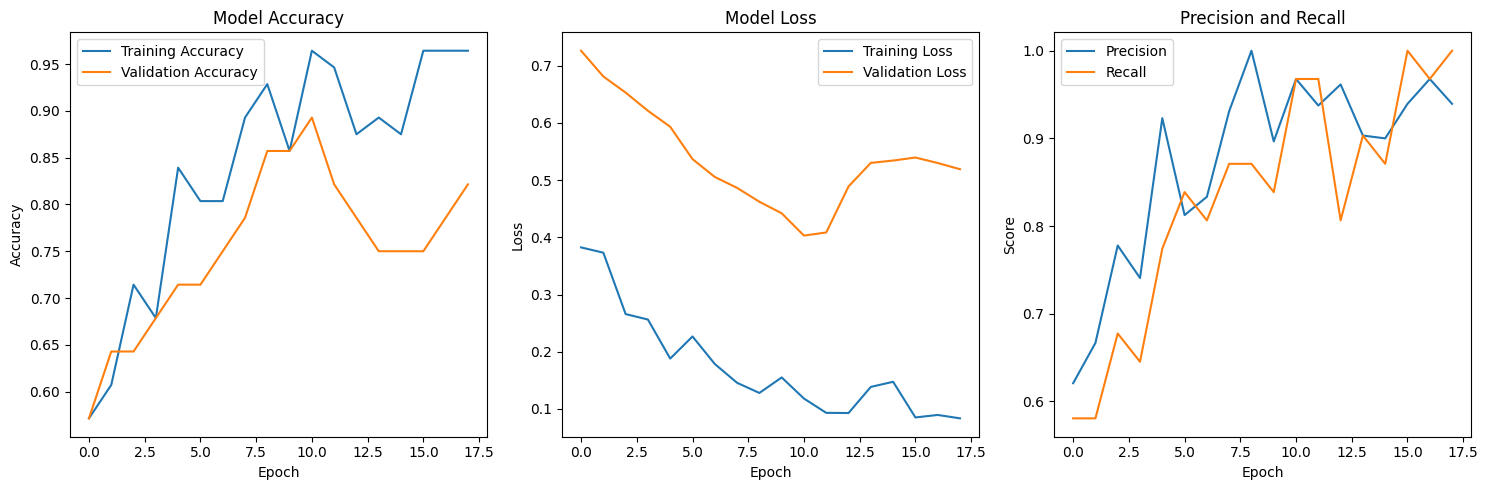

In [16]:
# Load both training histories
with open('training_history_fold1.json', 'r') as f:
    history_fold1 = json.load(f)
with open('training_history_fold2.json', 'r') as f:
    history_fold2 = json.load(f)

# Compare the best validation accuracies to determine best fold
best_val_acc1 = max(history_fold1['val_accuracy'])
best_val_acc2 = max(history_fold2['val_accuracy'])

# Use the history with better validation accuracy
best_history = history_fold1 if best_val_acc1 > best_val_acc2 else history_fold2

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precision-Recall plot
plt.subplot(1, 3, 3)
# Find which precision/recall keys are available
precision_key = None
recall_key = None

for key in best_history.keys():
    if key.startswith('precision_'):
        precision_key = key
    if key.startswith('recall_'):
        recall_key = key
        
if precision_key and recall_key:
    plt.plot(best_history[precision_key], label='Precision')
    plt.plot(best_history[recall_key], label='Recall')
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

plt.tight_layout()
plt.show()